# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [151]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import normaltest
from sklearn.preprocessing import MinMaxScaler


The number of samples: 186
The number of columns: 493


[Text(0.5, 1.0, 'Voorbeeld grafiek om te inspecteren hoe de data is verdeeld')]

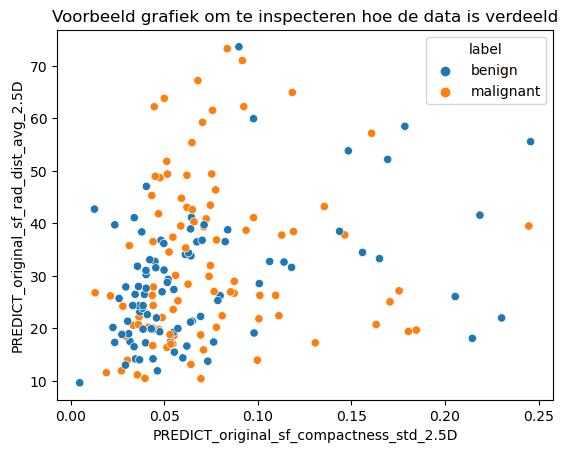

In [152]:
# Data loading functions. Uncomment the one you want to use
from worcliver.load_data import load_data

data = load_data()

# De label kolom even uit de dataset halen
X = data.drop('label', axis=1)   #drop the label category
y = data['label']                # Target variable die we proberen te voorspellen met het algoritme

n_samples = len(data.index)
n_features = len(X.columns)
print(f'The number of samples: {n_samples}')
print(f'The number of columns: {n_features}')

sb.scatterplot(x ="PREDICT_original_sf_compactness_std_2.5D", y = "PREDICT_original_sf_rad_dist_avg_2.5D", data=data, hue= "label").set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld")

### Deleting incomplete features and patients

In [164]:
nullen = X.eq(0.0).sum()
alle_nullen = sum(nullen)
print(f'Aantal nullen in de data: {alle_nullen}') 

X = X.fillna(0)

patient0={}
for patients in X.index:
    zero_count1 = (X.loc[patients]==0.0).sum()
    patient0[patients]=zero_count1

print(f"Hoeveelheid nullen per patient: {patient0}")

features0={}
for features in X.columns:
    zero_count2 = (X[features]==0).sum()
    features0[features]=zero_count2

features0 = {feature: count for feature, count in features0.items() if count!=0} #om alle volledige rijen, met 0 zeros eruit te halen. Vooral voor overzicht voor onszelf. 

print(f"Hoeveelheid nullen per feature: {features0}")

cutoff_feature = 0.9*n_samples
cutoff_sample = 0.9*n_features

X_drop = X[:]
Y_drop = y[:]

for feature, counts in features0.items():
    if counts >= cutoff_feature:
        X_drop = X_drop.drop(feature, axis=1)

for patient, count in patient0.items():
    if count >= cutoff_sample:
        X_drop = X_drop.drop(patient, axis=0)
        Y_drop = Y_drop.drop(patient, axis=0)
            
print(f"Dimesies dataframe na verwijderen unrelevant features {X_drop.shape}")



Aantal nullen in de data: 4341
Hoeveelheid nullen per patient: {'Liver-001_0': 25, 'Liver-002_0': 22, 'Liver-003_0': 22, 'Liver-004_0': 25, 'Liver-005_0': 22, 'Liver-006_0': 22, 'Liver-007_0': 25, 'Liver-008_0': 23, 'Liver-009_0': 25, 'Liver-010_0': 21, 'Liver-011_0': 25, 'Liver-012_0': 25, 'Liver-013_0': 24, 'Liver-014_0': 24, 'Liver-015_0': 23, 'Liver-016_0': 24, 'Liver-017_0': 22, 'Liver-018_0': 15, 'Liver-019_0': 22, 'Liver-020_0': 24, 'Liver-021_0': 22, 'Liver-022_0': 23, 'Liver-023_0': 25, 'Liver-024_0': 24, 'Liver-025_0': 27, 'Liver-026_0': 24, 'Liver-027_0': 24, 'Liver-028_0': 23, 'Liver-029_0': 23, 'Liver-030_0': 24, 'Liver-031_0': 24, 'Liver-032_0': 23, 'Liver-033_0': 24, 'Liver-034_0': 24, 'Liver-035_0': 23, 'Liver-036_0': 27, 'Liver-037_0': 24, 'Liver-038_0': 25, 'Liver-039_0': 24, 'Liver-040_0': 24, 'Liver-041_0': 18, 'Liver-042_0': 21, 'Liver-043_0': 26, 'Liver-044_0': 21, 'Liver-045_0': 24, 'Liver-046_0': 24, 'Liver-047_0': 25, 'Liver-048_0': 22, 'Liver-049_0': 25, 'Live

### Check normality

In [165]:
## Normality check
# P-waarde berekenen voor elke feature (statistiek test om te testen of H0: Data is normaal verdeeld)
p_values = []
for features in X_drop.columns:
    _, p = normaltest(X[features])
    p_values.append(p)

for i, features in enumerate(X_drop.columns):
    print("Variable:", features)
    print("p-value:", p_values[i])
    if p_values[i] < 0.05:
        print("The variable is not normally distributed")
    else:
        print("The variable is normally distributed")

c:\Users\lotte\miniconda3\lib\site-packages\scipy\stats\_stats_py.py:1670: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
c:\Users\lotte\miniconda3\lib\site-packages\scipy\stats\_stats_py.py:1774: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


Variable: PREDICT_original_sf_compactness_avg_2.5D
p-value: 1.145662534663526e-10
The variable is not normally distributed
Variable: PREDICT_original_sf_compactness_std_2.5D
p-value: 5.082112458342082e-16
The variable is not normally distributed
Variable: PREDICT_original_sf_rad_dist_avg_2.5D
p-value: 4.280298135711637e-06
The variable is not normally distributed
Variable: PREDICT_original_sf_rad_dist_std_2.5D
p-value: 2.4907255505070975e-14
The variable is not normally distributed
Variable: PREDICT_original_sf_roughness_avg_2.5D
p-value: 3.0991062140741755e-09
The variable is not normally distributed
Variable: PREDICT_original_sf_roughness_std_2.5D
p-value: 3.467791393271106e-23
The variable is not normally distributed
Variable: PREDICT_original_sf_convexity_avg_2.5D
p-value: 3.1390583766102673e-26
The variable is not normally distributed
Variable: PREDICT_original_sf_convexity_std_2.5D
p-value: 1.6120456237759444e-28
The variable is not normally distributed
Variable: PREDICT_original

## Splitting data into test and trainingset

In [167]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_drop, Y_drop, test_size=0.2, random_state=42)

print("Training set dimensies:", X_train.shape, y_train.shape)
print("Testing set dimensies:", X_test.shape, y_test.shape)


Training set dimensies: (148, 473) (148,)
Testing set dimensies: (38, 473) (38,)


VANAF HIER ALLEEN NOG MAAR DINGEN DOEN OP DE TRAININGSET!!

## Iets doen met de nullen die overbljiven

## Scaling the data

(148,)
0         benign
1         benign
2      malignant
3      malignant
4         benign
         ...    
143    malignant
144    malignant
145    malignant
146       benign
147    malignant
Name: label, Length: 148, dtype: object


[Text(0.5, 1.0, 'Voorbeeld grafiek om te inspecteren hoe de data is verdeeld na schalen')]

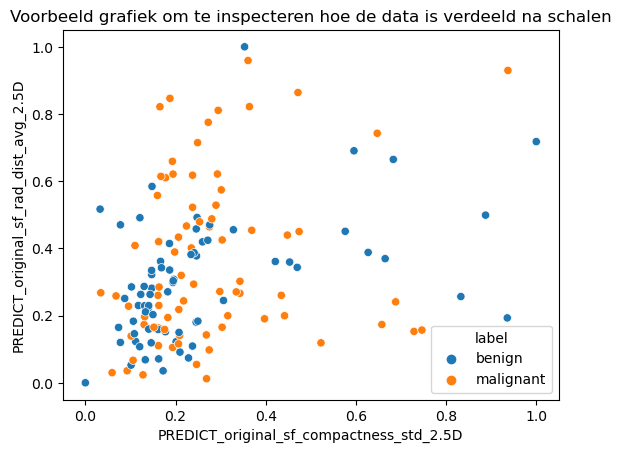

In [180]:
scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train) #Dit schaalt de data
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns) #de normalized functie zorgt voor een numpy array, dus moet weer even teruggezet worden in een dataframe. 


# Plotten om te zien hoe het er nu uitziet: 
X_train_normalized['label'] = y_train.values
sb.scatterplot(data=X_train_normalized, x="PREDICT_original_sf_compactness_std_2.5D", y="PREDICT_original_sf_rad_dist_avg_2.5D", hue='label').set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld na schalen")
